# Download Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install kaggle
!pip install tensorflow

In [3]:
import os

# Tentukan path file kaggle.json
kaggle_json_path = '/content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/.kaggle/kaggle.json'

# Pastikan folder .kaggle ada di direktori yang benar
os.makedirs('/root/.kaggle', exist_ok=True)

# Cek jika symlink sudah ada, jika ya, hapus
if os.path.exists('/root/.kaggle/kaggle.json'):
    os.remove('/root/.kaggle/kaggle.json')

# Buat symlink yang baru
os.symlink(kaggle_json_path, '/root/.kaggle/kaggle.json')


In [4]:
!kaggle datasets download -d mahmudulhaqueshawon/amazon-product-reviews -p /content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/

Dataset URL: https://www.kaggle.com/datasets/mahmudulhaqueshawon/amazon-product-reviews
License(s): MIT
amazon-product-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip /content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/amazon-product-reviews.zip -d /content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/

Archive:  /content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/amazon-product-reviews.zip
replace /content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/amazon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: /content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/amazon.csv  


# Implementation

## Import Dataset

In [3]:
import pandas as pd
import numpy as np
import spacy
import nltk
import re
import torch
import tensorflow as tf
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler

# Load spaCy model
nlp = spacy.load('en_core_web_sm')

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
nltk.download('stopwords')
nltk.download('words')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\andhi\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\andhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\andhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\andhi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [5]:
stop_words = set(stopwords.words('english'))

In [6]:
df_amazon = pd.read_csv('D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/amazon.csv')
df_amazon.dropna(inplace=True)
df_amazon.head()

,Text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1


<Axes: xlabel='rating', ylabel='count'>

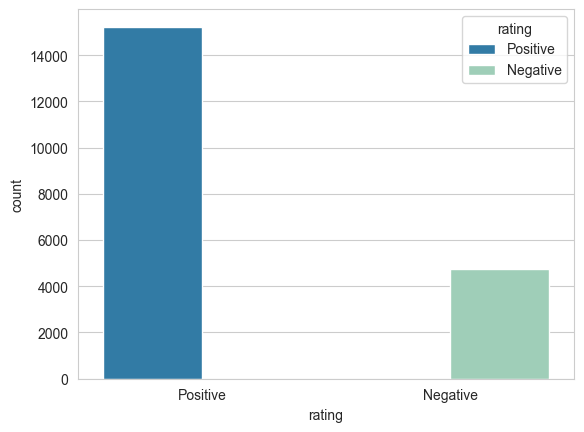

In [7]:
df_amazon['rating'] = df_amazon['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
sns.set_style('whitegrid')
sns.countplot(x='rating', data=df_amazon, palette='YlGnBu_r', hue='rating')

## Preprocessing Dataset

In [8]:
# Separate features (reviews) and target variable (rating)
X = df_amazon['Text']
y = df_amazon['label']

# Initialize RandomOverSampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with the resampled data
df_resampled = pd.DataFrame({'text': X_resampled.flatten(), 'label': y_resampled})

In [9]:
df_resampled

,text,label
0,This is the best apps acording to a bunch of ...,1
1,This is a pretty good version of the game for ...,1
2,this is a really . there are a bunch of levels...,1
3,"This is a silly game and can be frustrating, b...",1
4,This is a terrific game on any pad. Hrs of fun...,1
...,...,...
30455,Didn&apos;t do anything to make my phone bette...,0
30456,this app is total crap just like these 4-5 sta...,0
30457,Hey Hey Trojan: I'm going to pop a hole your l...,0
30458,I had to uninstall this app. It wasnt what I t...,0


In [10]:
df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30460 entries, 0 to 30459
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    30460 non-null  object
 1   label   30460 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 476.1+ KB


In [11]:
df_resampled['rating'] = df_resampled['label'].apply(lambda x: 'Positive' if x == 1 else 'Negative')
df_resampled[:10]

,text,label,rating
0,This is the best apps acording to a bunch of ...,1,Positive
1,This is a pretty good version of the game for ...,1,Positive
2,this is a really . there are a bunch of levels...,1,Positive
3,"This is a silly game and can be frustrating, b...",1,Positive
4,This is a terrific game on any pad. Hrs of fun...,1,Positive
5,This is a very entertaining game! You don't h...,1,Positive
6,this is awesome and you don't need wi ti to pl...,1,Positive
7,this is awesome I bet no one even reads the re...,1,Positive
8,This is basicly the free version but with ads....,1,Positive
9,this is by far the best free app that is avail...,1,Positive


<Axes: xlabel='rating', ylabel='count'>

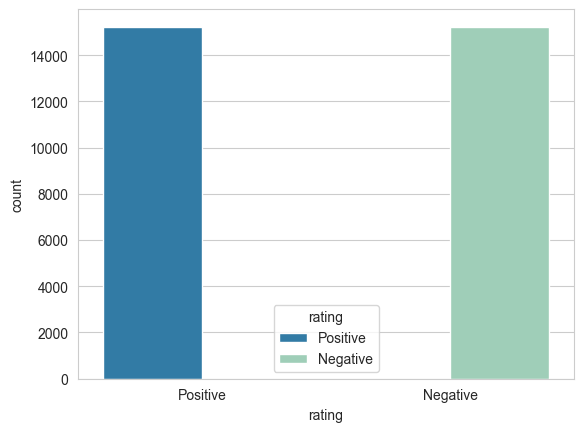

In [12]:
sns.set_style('whitegrid')
sns.countplot(x='rating', data=df_resampled, palette='YlGnBu_r', hue='rating')

In [13]:
def preprocess_text(text):
    # Remove noisy characters and extra spaces
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    # Lowercase text
    text = text.lower()
    # Tokenize text and remove stopwords
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

In [14]:
df_resampled['clean_text'] = df_resampled['text'].apply(preprocess_text)

In [15]:
df = df_resampled[['clean_text', 'label']]
df

,clean_text,label
0,best apps acording bunch people agree bombs eg...,1
1,pretty good version game free lots different l...,1
2,really bunch levels find golden eggs super fun,1
3,silly game frustrating lots fun definitely rec...,1
4,terrific game pad hrs fun grandkids love great...,1
...,...,...
30455,didnapost anything make phone better waste tim...,0
30456,app total crap like 45 star reviews want enhan...,0
30457,hey hey trojan im going pop hole logic touring...,0
30458,uninstall app wasnt thought would didnt play w...,0


In [16]:
# # One-hot encoding untuk kolom 'rating'
# one_hot = pd.get_dummies(df["rating"])

# # Drop kolom 'rating' yang asli
# df.drop(['rating'], axis=1, inplace=True)

# # Gabungkan hasil one-hot encoding ke dataframe
# df = pd.concat([df, one_hot], axis=1)

# # Mengonversi nilai True/False menjadi 1/0
# df["Negative"] = df["Negative"].astype(int)
# df["Positive"] = df["Positive"].astype(int)

# df

In [17]:
X = df['clean_text'].values
y = df.drop('clean_text', axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Sentiment Analysis using LSTM

In [18]:
!pip show tensorflow

Name: tensorflow
Version: 2.13.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: c:\users\andhi\anaconda3\envs\analysis_product_review\lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [31]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from huggingface_hub import HfApi, create_repo, upload_file
from huggingface_hub import hf_hub_download

c:\Users\andhi\anaconda3\envs\analysis_product_review\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [56]:
# Mengatur parameter
max_words = 5000  # Jumlah kata yang akan dipertimbangkan untuk tokenisasi
max_len = 128  # Panjang maksimum input sequence

# Tokenisasi teks
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

# Mengonversi teks menjadi urutan numerik dan melakukan padding
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [ ]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=128))
model.add(tf.keras.layers.LSTM(128, return_sequences=False))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy'],
    run_eagerly=True
)

In [58]:
# Melatih model
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_test_pad, y_test))

# Evaluasi model
loss, accuracy = model.evaluate(X_test_pad, y_test)

accuracy, loss

Epoch 1/10
381/381 [==============================] - 554s 1s/step - loss: 0.3172 - accuracy: 0.8638 - val_loss: 0.2371 - val_accuracy: 0.9114
Epoch 2/10
381/381 [==============================] - 458s 1s/step - loss: 0.1747 - accuracy: 0.9374 - val_loss: 0.2126 - val_accuracy: 0.9224
Epoch 3/10
381/381 [==============================] - 515s 1s/step - loss: 0.1128 - accuracy: 0.9613 - val_loss: 0.2257 - val_accuracy: 0.9306
Epoch 4/10
381/381 [==============================] - 447s 1s/step - loss: 0.0766 - accuracy: 0.9726 - val_loss: 0.2659 - val_accuracy: 0.9334
Epoch 5/10
381/381 [==============================] - 484s 1s/step - loss: 0.0516 - accuracy: 0.9819 - val_loss: 0.2425 - val_accuracy: 0.9373
Epoch 6/10
381/381 [==============================] - 491s 1s/step - loss: 0.0359 - accuracy: 0.9876 - val_loss: 0.3051 - val_accuracy: 0.9373
Epoch 7/10
381/381 [==============================] - 495s 1s/step - loss: 0.0259 - accuracy: 0.9910 - val_loss: 0.3223 - val_accuracy: 0.9424

(0.937951385974884, 0.39136242866516113)

In [ ]:
# 1. Menyimpan model Keras ke dalam satu file .h5
model.save('D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/sentiment_lstm_model.h5')
print("Model telah disimpan ke 'sentiment_lstm_model.h5'")

# 2. Menyimpan tokenizer menggunakan pickle
with open('D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
print("Tokenizer telah disimpan ke 'tokenizer.pickle'")

c:\Users\andhi\anaconda3\envs\analysis_product_review\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Model telah disimpan ke 'sentiment_lstm_model.h5'
Tokenizer telah disimpan ke 'tokenizer.pickle'


In [60]:
model_name = "lstm-sentiment-product_review"  # contoh nama
repo_id = f"andhikaputrab/{model_name}"  # ganti 'username' dengan username Hugging Face Anda

# Buat repo (jika belum ada)
create_repo(repo_id, exist_ok=True, private=False)

# Upload model dan tokenizer
upload_file(
    path_or_fileobj="D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/sentiment_lstm_model.h5",
    path_in_repo="sentiment_lstm_model.h5",
    repo_id=repo_id,
    commit_message="Upload LSTM sentiment model"
)

upload_file(
    path_or_fileobj="D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/tokenizer.pickle",
    path_in_repo="tokenizer.pickle",
    repo_id=repo_id,
    commit_message="Upload tokenizer"
)

print(f"Model berhasil diunggah ke: https://huggingface.co/{repo_id}")

sentiment_lstm_model.h5: 100%|██████████| 27.6M/27.6M [00:14<00:00, 1.92MB/s]
tokenizer.pickle: 100%|██████████| 870k/870k [00:01<00:00, 578kB/s] 


Model berhasil diunggah ke: https://huggingface.co/andhikaputrab/lstm-sentiment-product_review


In [61]:
model_path = "D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/sentiment_lstm_model.h5"
tokenizer_path = "D:/Kuliah/portofolio/sentiment_analysis_product_review/artifacts/tokenizer.pickle"

lstm_model = tf.keras.models.load_model(model_path)
with open(tokenizer_path, 'rb') as f:
    tokenizer = pickle.load(f)

print("Model dan tokenizer berhasil dimuat dari Hugging Face.")

Model dan tokenizer berhasil dimuat dari Hugging Face.


In [62]:
def predict(model, test_data, threshold = 0.5):
    return (model.predict(test_data) >= threshold).astype(int)

labels = predict(model, X_test_pad, 0.1)

191/191 [==============================] - 61s 314ms/step


In [ ]:
print("Results:")
print("Test Accuracy:", accuracy_score(y_test, labels))
print("\nClassification Report:")
print(classification_report(y_test, labels))

Results:
Test Accuracy: 0.9438608010505581

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.96      0.94      3021
           1       0.96      0.93      0.94      3071

    accuracy                           0.94      6092
   macro avg       0.94      0.94      0.94      6092
weighted avg       0.94      0.94      0.94      6092



In [75]:
# Prediksi kalimat baru

def predict_new_text(model, new_text, tokenizer, max_len=128):
    # Tokenisasi teks baru
    new_text_seq = tokenizer.texts_to_sequences([new_text])

    # Padding agar panjang sequence sesuai dengan max_len
    new_text_pad = pad_sequences(new_text_seq, maxlen=max_len)

    # Melakukan prediksi
    prediction = model.predict(new_text_pad)

    # Menggunakan threshold untuk klasifikasi (misalnya 0.5 untuk binary classification)
    sentiment = (prediction >= 0.5).astype(int)

    return sentiment[0][0]

# Contoh penggunaan dengan kalimat baru
new_sentence = "i like this product"
predicted_label = predict_new_text(lstm_model, new_sentence, tokenizer)

# Menampilkan hasil prediksi
if predicted_label == 1:
    print("The sentiment of the sentence is: Positive")
else:
    print("The sentiment of the sentence is: Negative")

1/1 [==============================] - 0s 51ms/step
The sentiment of the sentence is: Negative


## Sentiment Analysis using distilBERT

In [33]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [34]:
# from google.colab import userdata
from huggingface_hub import login
# from huggingface_hub import notebook_login

login(HF_TOKEN)
# notebook_login(distilBERT_token)

In [35]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch

In [36]:
from transformers import AutoTokenizer

model = "distilbert/distilbert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model)

# Buat Dataset Hugging Face dari data training dan testing
train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})

def tokenize(batch):
    return tokenizer_bert(batch['text'], padding="max_length", truncation=True, max_length=128)

# Tokenisasi dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/24368 [00:00<?, ? examples/s]

Map:   0%|          | 0/6092 [00:00<?, ? examples/s]

In [37]:
print(train_dataset)
print(test_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 24368
})
Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 6092
})


In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_labels = 2
id2label = {
    0: "Negative",
    1: "Positive"
}
label2id = {
    "Negative": 0,
    "Positive": 1,
}

model_bert = AutoModelForSequenceClassification.from_pretrained(model, num_labels=num_labels, id2label=id2label, label2id=label2id).to(device)

In [ ]:
# # y_train_list = [int(i) for i in y_train]
# # y_test_list = [int(i) for i in y_test]
# # X_train_list = list(X_train)
# # X_test_list = list(X_test)

# # Convert lists to numpy arrays before creating the Dataset
# X_train_np = np.asarray(X_train)
# X_test_np = np.asarray(X_test)
# y_train_np = np.asarray(y_train).flatten()
# y_test_np = np.asarray(y_test).flatten()


# # Buat Dataset Hugging Face dari data training dan testing
# train_dataset = Dataset.from_dict({"text": X_train_np, "label": y_train_np.tolist()})
# test_dataset = Dataset.from_dict({"text": X_test_np, "label": y_test_np.tolist()})

# def tokenize(batch):
#     return tokenizer_bert(batch['text'], padding="max_length", truncation=True, max_length=128) # You can adjust max_length

# # Tokenisasi dataset
# train_dataset = train_dataset.map(tokenize, batched=True)
# test_dataset = test_dataset.map(tokenize, batched=True)

# # Set the format for PyTorch tensors
# train_dataset.set_format("torch")
# test_dataset.set_format("torch")

In [39]:
# Fungsi evaluasi untuk metrik akurasi, precision, recall, f1
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [44]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(train_dataset)
model_repo_name = "distilbert-base-uncased"
model_name = f"/content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/results/{model_repo_name}-finetuned-product-review"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    hub_model_id="andhikaputrab/distilbert-base-uncased-finetuned-product-review",
    log_level="error"
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer_bert
)

/tmp/ipython-input-39828853.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [45]:
# Training model (fine-tuning)
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.191645,0.945666,0.961590,0.929339,0.945190
2,No log,0.181346,0.954531,0.966600,0.942364,0.954328


TrainOutput(global_step=762, training_loss=0.09771949788091064, metrics={'train_runtime': 559.2244, 'train_samples_per_second': 87.149, 'train_steps_per_second': 1.363, 'total_flos': 1613982785224704.0, 'train_loss': 0.09771949788091064, 'epoch': 2.0})

In [46]:
# Evaluasi model pada data test
eval_results = trainer.evaluate()
print(eval_results)

{'eval_loss': 0.18134628236293793, 'eval_accuracy': 0.9545305318450427, 'eval_precision': 0.9665998663994656, 'eval_recall': 0.9423640507977857, 'eval_f1': 0.9543281121187139, 'eval_runtime': 23.4149, 'eval_samples_per_second': 260.176, 'eval_steps_per_second': 4.1, 'epoch': 2.0}


In [47]:
# Memuat model dan tokenizer yang sudah dilatih
saved_model = AutoModelForSequenceClassification.from_pretrained("andhikaputrab/distilbert-base-uncased-finetuned-product-review")
saved_tokenizer = AutoTokenizer.from_pretrained("andhikaputrab/distilbert-base-uncased-finetuned-product-review")

# # Fungsi prediksi
# def predict(texts):
#     inputs = saved_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
#     outputs = saved_model(**inputs)
#     predictions = torch.argmax(outputs.logits, dim=-1)
#     return predictions

# # Contoh penggunaan
# predictions = predict("This is a great product!")
# print(predictions)

def analyze_sentiment(text):
    # Pastikan input adalah list
    if isinstance(text, str):
        texts = [text]
    else:
        texts = text

    inputs = saved_tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = saved_model(**inputs)

    predictions = torch.argmax(outputs.logits, dim=-1)
    predicted_labels = [saved_model.config.id2label[pred.item()] for pred in predictions]

    # Jika hanya satu text, return langsung
    if len(predicted_labels) == 1:
        return f"Sentiment review tersebut adalah {predicted_labels[0]}."
    else:
        # Jika banyak text, return list hasil
        results = [f"Sentiment review tersebut adalah {label}." for label in predicted_labels]
        return results

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [49]:
print(analyze_sentiment("This is a great product, but i hate it!"))

Sentiment review tersebut adalah Negative.


## Sentiment Analysis using LLM

In [ ]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')
from huggingface_hub import login
# from huggingface_hub import notebook_login

login(HF_TOKEN)
# notebook_login(distilBERT_token)

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
model_name = "Qwen/Qwen2.5-0.5B"
tokenizer_qwen = AutoTokenizer.from_pretrained(model_name)
model_qwen = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)  # Sentiment analysis (2 classes)
model_qwen.to(device)

Qwen2ForSequenceClassification(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2Attention(
          (q_proj): Linear(in_features=896, out_features=896, bias=True)
          (k_proj): Linear(in_features=896, out_features=128, bias=True)
          (v_proj): Linear(in_features=896, out_features=128, bias=True)
          (o_proj): Linear(in_features=896, out_features=896, bias=False)
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    )
    (norm): Qwen2RMSNorm((896,), eps=1e-06)
    (rotary_emb): Q

In [ ]:
# Membuat dataset Hugging Face
train_data = {"text": X_train, "label": y_train.flatten()}
test_data = {"text": X_test, "label": y_test.flatten()}

train_dataset_LLM = Dataset.from_dict(train_data)
test_dataset_LLM = Dataset.from_dict(test_data)

In [ ]:
def tokenize(batch):
    return tokenizer_qwen(batch['text'], padding="max_length", truncation=True, max_length=128)

# Tokenisasi dataset
train_dataset_LLM = train_dataset_LLM.map(tokenize, batched=True)
test_dataset_LLM = train_dataset_LLM.map(tokenize, batched=True)

Map:   0%|          | 0/24368 [00:00<?, ? examples/s]

Map:   0%|          | 0/24368 [00:00<?, ? examples/s]

In [ ]:
# Fungsi evaluasi untuk metrik akurasi, precision, recall, f1
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(train_dataset_LLM)
model_repo_name = "Qwen2.5-0.5B"
model_name = f"/content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/results/{model_repo_name}-finetuned-product-review"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    push_to_hub=True,
    log_level="error"
)

trainer_llm = Trainer(
    model=model_qwen,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset_LLM,
    eval_dataset=test_dataset_LLM,
    tokenizer=tokenizer_qwen
)

<ipython-input-52-cb6214ca30c4>:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_llm = Trainer(


In [ ]:
# Training model (fine-tuning)
trainer_llm.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: andhikaputrab (andhikaputrab-telkom-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 28.00 MiB. GPU 0 has a total capacity of 14.74 GiB of which 8.12 MiB is free. Process 199085 has 14.73 GiB memory in use. Of the allocated memory 13.91 GiB is allocated by PyTorch, and 712.04 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Evaluasi model pada data test
eval_llm = trainer_llm.evaluate()
print(eval_llm)

In [ ]:
# Memuat model dan tokenizer yang sudah dilatih
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/results/{model_repo_name}-finetuned-product-review")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/Kuliah/Tubes_SentimentAnalysis/results/{model_repo_name}-finetuned-product-review")

# Fungsi prediksi
def predict(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1)
    return predictions

# Contoh penggunaan
predictions = predict(["This is a great product!", "I don't like this product."])
print(predictions)
